# Training an allosteric network

Begin with a few package imports:

In [1]:
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt

from packing_utils import *
from allosteric_utils import *
from plot_imports import *

### Network generation

Generate a contact network from a disk packing simulation to use as the elastic network:

In [2]:
n = 64 # number of disks/nodes
seed = 0

net = Packing(n, rfac=0.8, seed=seed)
net.params['contact'] = 0.02 # reduce the default contact repulsion
net.generate()

progress: 100%|####################################################################| 1000.00/1000.00 [00:03<00:00]


Use the network graph to initialize an Allosteric Class object, and manually select a source and target pair:

<IPython.core.display.Javascript object>


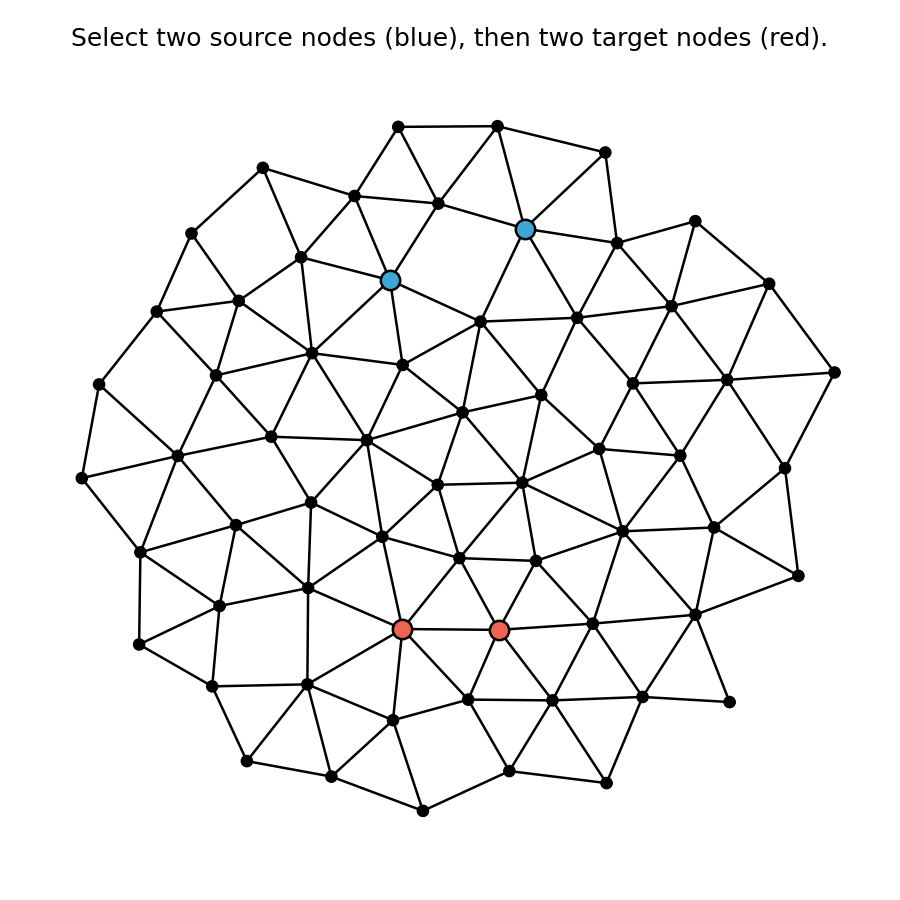

In [3]:
%matplotlib notebook

allo = Allosteric(net.graph, auto=False, seed=seed)

Save the untrained network to a file:

In [4]:
allo.save('allo_{:d}_{:d}.txt'.format(n,seed))

### Training

Specify a source and target strain to apply, training time, and training method.

In [5]:
es = 0.2                # source strain of 20%
et = 0.2                # target strain of 20%
ka = 100.               # stiffness of spring for applied strain
duration = 2e7          # training time
frames = 200            # number of output frames
train = 2               # 1 trains bond rest lengths, 2 trains bond stiffnesses
method = 'learning'     # learning rule to use, 'aging' (directed aging) or 'learning' (coupled learning)

# compute the mean square bond length as a normalization factor
l2 = np.mean([edge[2]['length']**2 for edge in allo.graph.edges(data=True)])

eta = 1e-1              # learning rate
alpha = 1e-3/l2         # aging rate
vmin = 1e-3             # minimum allowed stiffness
vsmooth = 1e-2          # stiffness value at which to begin smooth ramp down to vmin

Initially, all bond stiffnesses are equal to 1:

<IPython.core.display.Javascript object>


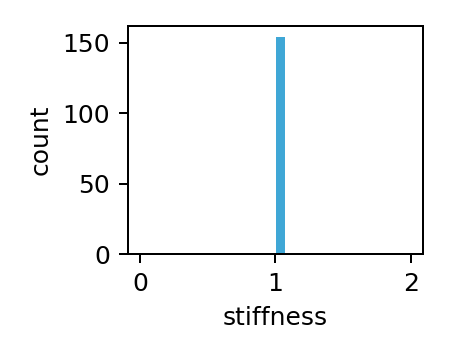

In [6]:
%matplotlib notebook

k = allo.distribution_plot(kind='stiffness', vmin=0, vmax=2)

Since the network is untrained, applying a strain at the source (blue curve) produces no strain at the target (red curve):

progress: 100%|###########################################################9| 20000000.00/20000000.00 [00:03<00:00]


<IPython.core.display.Javascript object>


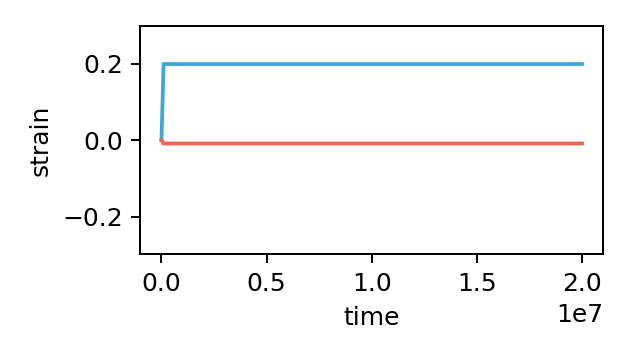

In [7]:
%matplotlib notebook

allo.reset_init() # set to equilibrium
allo.solve(duration=duration, frames=frames, T=0, applied_args=(es, 0, ka))
allo.strain_plot()

Train the system:

In [8]:
allo.solve(duration=duration, frames=frames, T=0, applied_args=(es, et, ka),
           train=train, method=method, eta=eta, alpha=alpha, vmin=vmin, vsmooth=vsmooth)

progress: 100%|###########################################################9| 20000000.00/20000000.00 [00:04<00:00]


0

We can view the increase in the target strain over time:

<IPython.core.display.Javascript object>


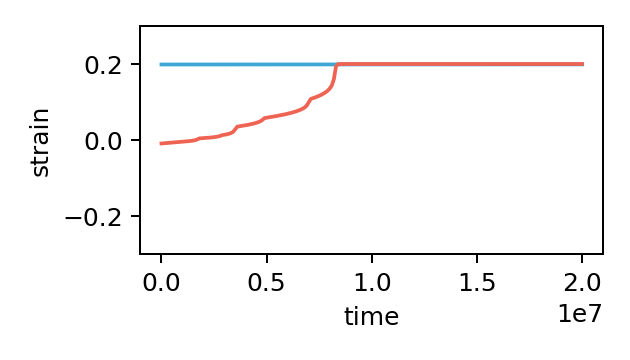

In [9]:
%matplotlib notebook

allo.strain_plot()

### Visualization

View the final distribution of stiffnesses:

<IPython.core.display.Javascript object>


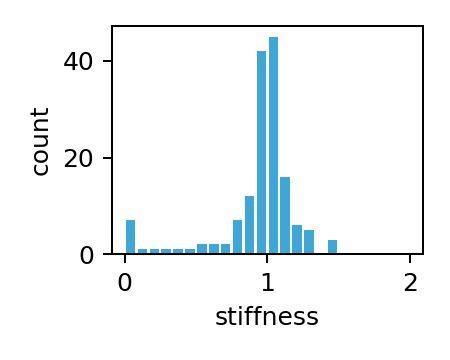

In [10]:
%matplotlib notebook

k = allo.distribution_plot(kind='stiffness', vmin=0, vmax=2, nbins=25)

Also visualize which bonds weakened (reds) and which bonds strengthened (blues):

<IPython.core.display.Javascript object>


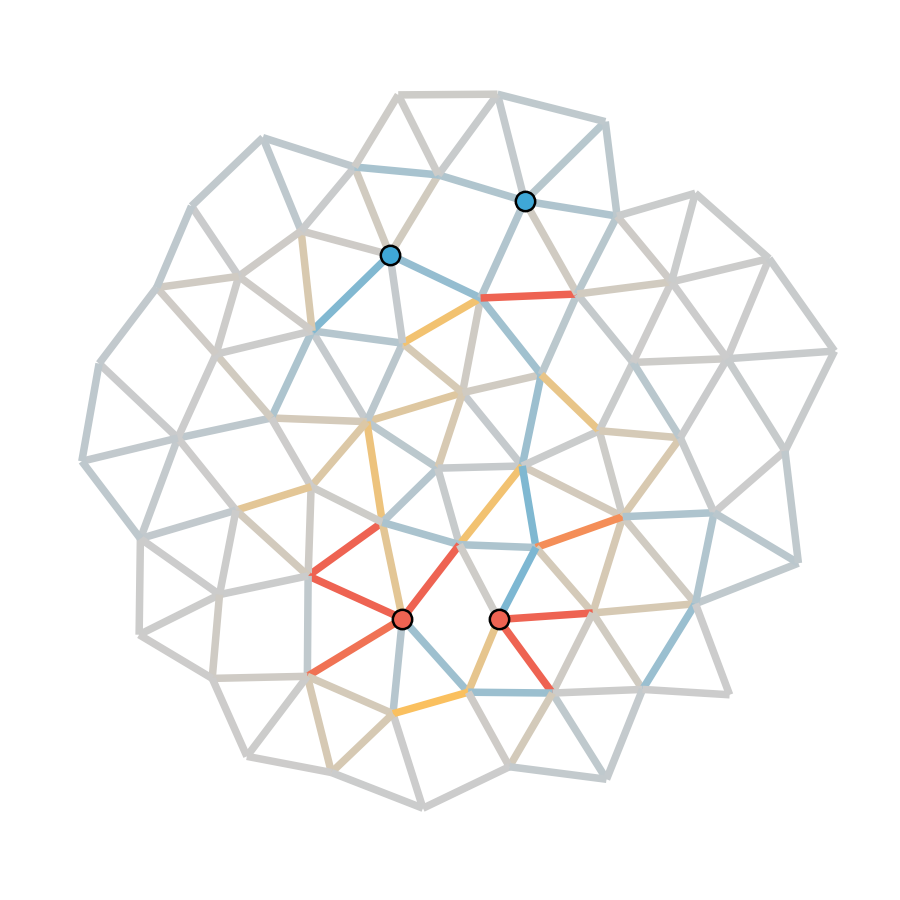

In [11]:
%matplotlib notebook

allo.reset_init() # reset network to its equilibrium state for visualization

cmap = continuous_cmap([pal['red'], pal['yellow'], np.array([0.8,0.8,0.8]),
                        pal['blue'], pal['purple']], [0,0.1,0.5,0.9,1])
allo.color_plot(cmap, vmin=0, vmax=2)

### Animation

Apply a sinusoidal strain at the source and monitor the target:

progress: 100%|############################################################| 40000000.00/40000000.00 [00:00<00:00]


<IPython.core.display.Javascript object>


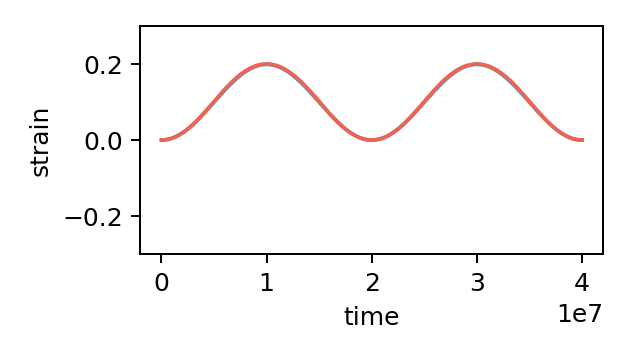

In [12]:
%matplotlib notebook

allo.reset_init()

duration = 4e7
frames = 200
period = 2e7

allo.solve(duration=duration, frames=frames, T=period, applied_args=(es, 0, ka))
allo.strain_plot()

The following cell produces a movie of the network as it undergoes the sinusoidal strain:

In [ ]:
%matplotlib inline

ani = allo.animate()
HTML(ani.to_html5_video())